In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gti-upm/leapgestrecog")

print("Path to dataset files:", path)


100%|██████████| 2.13G/2.13G [00:25<00:00, 90.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gti-upm/leapgestrecog/versions/1


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import glob


In [ ]:
import os
import cv2
import numpy as np
import kagglehub
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Step 1: Download dataset
path = kagglehub.dataset_download("gti-upm/leapgestrecog")

# Step 2: Detect actual dataset folder
for folder in os.listdir(path):
    if folder.lower().startswith("leapgestrecog"):
        data_dir = os.path.join(path, folder)
        break

if not data_dir or not os.path.exists(data_dir):
    raise Exception("Dataset folder not found.")

print("✅ Dataset Path:", data_dir)

# Step 3: Find gesture folders
gesture_folders = sorted([
    f for f in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, f))
])
print("✅ Gesture folders:", gesture_folders)

# Step 4: Load images from subject folders inside gesture folders
image_size = 64
X = []
y = []
label_dict = {name: idx for idx, name in enumerate(gesture_folders)}

for gesture in gesture_folders:
    gesture_path = os.path.join(data_dir, gesture)
    for subject_folder in os.listdir(gesture_path):
        subject_path = os.path.join(gesture_path, subject_folder)
        if not os.path.isdir(subject_path):
            continue
        for file in os.listdir(subject_path):
            if file.endswith('.png'):
                img_path = os.path.join(subject_path, file)
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (image_size, image_size))
                    X.append(img)
                    y.append(label_dict[gesture])
                except Exception as e:
                    print(f"❌ Error loading {img_path}: {e}")

# Step 5: Prepare dataset
X = np.array(X).reshape(-1, image_size, image_size, 1) / 255.0
y = to_categorical(np.array(y), num_classes=len(gesture_folders))

# Step 6: Split
if len(X) == 0:
    raise ValueError("No images were loaded. Check folder paths and contents.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Data loaded:")
print(f" - Total samples: {len(X)}")
print(f" - Train shape: {X_train.shape}")
print(f" - Test shape: {X_test.shape}")


✅ Dataset Path: /root/.cache/kagglehub/datasets/gti-upm/leapgestrecog/versions/1/leapGestRecog
✅ Gesture folders: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']
✅ Data loaded:
 - Total samples: 20000
 - Train shape: (16000, 64, 64, 1)
 - Test shape: (4000, 64, 64, 1)


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,866 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 81s 174ms/step - accuracy: 0.6181 - loss: 1.0873 - val_accuracy: 0.9919 - val_loss: 0.0287
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 78s 166ms/step - accuracy: 0.9754 - loss: 0.0751 - val_accuracy: 0.9912 - val_loss: 0.0140
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 80s 162ms/step - accuracy: 0.9829 - loss: 0.0375 - val_accuracy: 0.9900 - val_loss: 0.0168
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - accuracy: 0.9859 - loss: 0.0343 - val_accuracy: 0.9912 - val_loss: 0.0137
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 80s 158ms/step - accuracy: 0.9878 - loss: 0.0256 - val_accuracy: 0.9912 - val_loss: 0.0127
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 84s 163ms/step - accuracy: 0.9901 - loss: 0.0234 - val_accuracy: 0.9912 - val_loss: 0.0151
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 74s 163ms/step - accuracy: 0.9882 - loss: 0.0262 - val_accuracy: 0.9906 - val_loss: 0.0126
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 82s 163ms/step - accuracy: 0.9902 - loss: 0

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9933 - loss: 0.0122
Test Accuracy: 99.27%


125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step


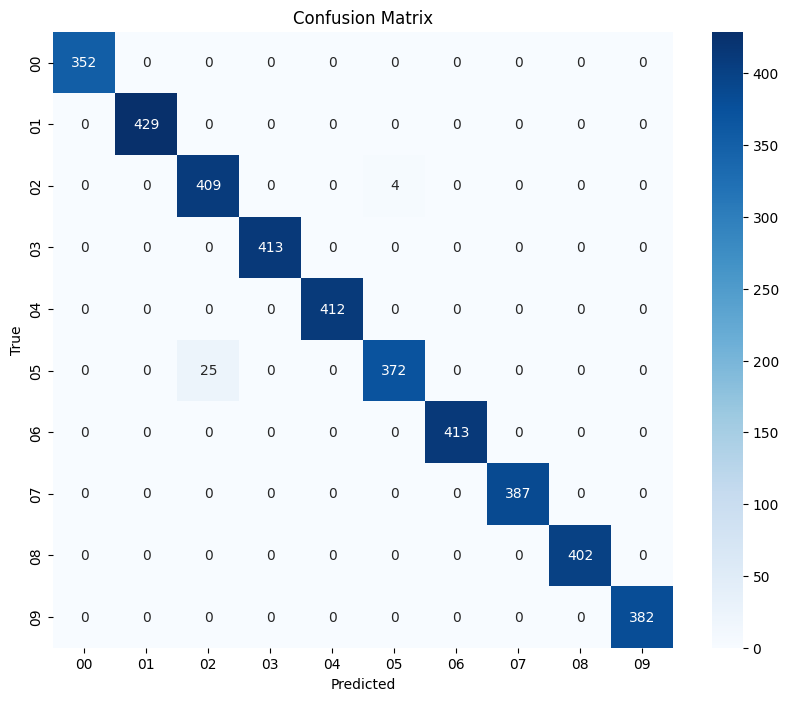

📊 Classification Report:

              precision    recall  f1-score   support

          00       1.00      1.00      1.00       352
          01       1.00      1.00      1.00       429
          02       0.94      0.99      0.97       413
          03       1.00      1.00      1.00       413
          04       1.00      1.00      1.00       412
          05       0.99      0.94      0.96       397
          06       1.00      1.00      1.00       413
          07       1.00      1.00      1.00       387
          08       1.00      1.00      1.00       402
          09       1.00      1.00      1.00       382

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=gesture_folders,
            yticklabels=gesture_folders)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("📊 Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=gesture_folders))
